In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

from tqdm import tqdm
from torch.autograd import Variable
from PIL import Image

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        
        self.f = []
        for name, module in models.resnet50(pretrained=True).named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        
        self.g = nn.Sequential(nn.Linear(2048, 512), nn.BatchNorm1d(512) ,nn.ReLU(inplace=True) ,nn.Linear(512, 128))
        self.out = nn.Linear(128,10)
    
    def forward(self, x):
        #x = self.backbone(x) 
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        #print(feature.shape)
        x = self.g(feature)
        output = self.out(x)
        return output    

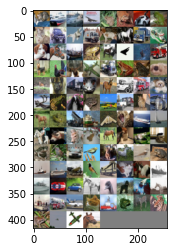

<built-in method size of Tensor object at 0x0000016689FE7AE8>
100


In [17]:
def Imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

"""
image1 = Image.open('C:\\Users\\69499\\Desktop\\下载.jpg').convert('RGB')
tensor = transform(image1)

tensor = Variable(torch.unsqueeze(tensor, dim=0).float(), requires_grad=False)
print(tensor.shape)
"""



data = iter(test_dataloader)
image ,target = data.next()
Imshow(torchvision.utils.make_grid(image, padding=0))
print(target.size)
print(target.size(0))

model = Model()
out = model(image)



In [44]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model.to(device)

def train(model, data_loader, optimizer, batch_size):
    total_loss = 0.0
    total_num = 0
    train_bar = tqdm(data_loader)
    for image, target in train_bar:
        image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
        model.to(device)
        out = model(image)
        optimizer.zero_grad()
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        total_num = total_num + batch_size
        train_bar.set_description("Train Epoch [{}/{}], loss = {:.4f} ".format(epoch, epochs, total_loss/total_num))   
        
def test(model, data_loader):
    total_num = 0
    accuracy = 0.0
    test_bar = tqdm(data_loader)
    with torch.no_grad():
        for image, target in test_bar:
            model.to(device)
            image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = model(image)
            _, predicts = torch.max(out.data, 1)
            total_num = total_num + target.size(0)
            accuracy = accuracy + (target == predicts).sum().item()
            test_bar.set_description("Accuracy of the network on the 10000 test images: {:.4f}".format(100 * accuracy / total_num))
            

cuda:0


In [45]:
torch.cuda.empty_cache()

In [4]:
batch_size = 100
epochs = 2
for epoch in range(1,epochs+1):
    train(model, train_dataloader, optimizer, batch_size)
    test(model, test_dataloader)

1
2
